In [0]:

import torchvision
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import albumentations as A
import cv2
from torchsummary import summary
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from albumentations import Compose, Normalize, HorizontalFlip, Cutout, Rotate, RandomCrop, PadIfNeeded
from albumentations.pytorch import ToTensor

In [0]:
#!pip install -U git+https://github.com/albu/albumentations --no-cache-dir


In [2]:
#import Model as Md
import Misclassified_image as MC
from TrainTestandUtils import TrainTestandUtils as Tt
import cyclic_lr as clr
from Albumentations import AlbumentationTransforms
from GradCAM import GradCAM
from LR_range_test import LR_test
from lr_finder import LRFinder
from Utils import *
import ResnetModel as rn
#import resnet_new as rn

  pip install torch-lr-finder -v --global-option="amp"


In [0]:
from tinyimagenet import TinyImageNetDataSet


In [0]:
#!pip install --no-cache-dir git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation library is successfully installed!"

In [5]:
import albumentations as A
import cv2
channel_means = (0.442,0.442,0.442)
channel_stdevs = (0.278, 0.278, 0.278)
train_transform = AlbumentationTransforms([       
                                                                
                                      A.HorizontalFlip(p = 0.7),
                                      A.PadIfNeeded(min_height=70, min_width=70, border_mode=4, value=None, mask_value=None, always_apply=False, p=1.0),
                                      A.RandomCrop(64, 64, always_apply=False, p=1.0),
                                      A.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
                                      A.Normalize(mean=channel_means, std=channel_stdevs),
                                      A.Cutout(num_holes=1, max_h_size=32,max_w_size = 32,p=0.7) 
                                       ])
test_transform = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])
train_dataset , test_dataset,classes = TinyImageNetDataSet(train_split = 70,test_transforms = test_transform,train_transforms = train_transform)

Images already downloaded...


In [6]:
train_dataset , test_dataset,classes = TinyImageNetDataSet(train_split = 70,test_transforms = test_transform,train_transforms = train_transform)


Images already downloaded...


In [7]:
len(test_dataset)

33000

In [0]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                          shuffle=True, num_workers=4, pin_memory=True)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                         shuffle=False, num_workers=4)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cuda


In [0]:
from ResnetModel import ResNet18

model = ResNet18(num_classes=200).to(device)



In [11]:
#model = torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)

#from ResnetModel import ResNet18

#model = rn(num_classes=200)

summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR,StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay = 0.0001,nesterov = True ) 
criterion = nn.CrossEntropyLoss()
scheduler = OneCycleLR(optimizer, max_lr = 0.02, total_steps=None, epochs=30, steps_per_epoch=len(trainloader), pct_start=1/3, anneal_strategy='linear', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =10)

In [0]:
new_model = Tt(model=model,
               device=device,
               optimizer=optimizer,
               criterion=criterion,
               scheduler=scheduler,
               trainloader=trainloader,
               testloader=testloader,
               epochs=25,
               input_size=(3,64,64),
               classes=classes)

In [14]:
new_model.runModel()

  0%|          | 0/602 [00:00<?, ?it/s]

EPOCH  1


Loss=4.280295372009277 Batch_id=601 Accuracy=6.40: 100%|██████████| 602/602 [07:12<00:00,  1.39it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Test set: Average loss: 0.0337, Accuracy: 3369/33000 (10.21%)

EPOCH  2


Loss=3.6715235710144043 Batch_id=601 Accuracy=14.82: 100%|██████████| 602/602 [07:12<00:00,  1.39it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Test set: Average loss: 0.0289, Accuracy: 6075/33000 (18.41%)

EPOCH  3


Loss=3.2508881092071533 Batch_id=601 Accuracy=20.82: 100%|██████████| 602/602 [07:12<00:00,  1.39it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Test set: Average loss: 0.0311, Accuracy: 5764/33000 (17.47%)

EPOCH  4


Loss=3.4585280418395996 Batch_id=601 Accuracy=25.33: 100%|██████████| 602/602 [07:12<00:00,  1.39it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Test set: Average loss: 0.0256, Accuracy: 8375/33000 (25.38%)

EPOCH  5


Loss=3.469433546066284 Batch_id=601 Accuracy=28.87: 100%|██████████| 602/602 [07:13<00:00,  1.39it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Test set: Average loss: 0.0256, Accuracy: 8730/33000 (26.45%)

EPOCH  6


Loss=3.0608675479888916 Batch_id=601 Accuracy=32.07: 100%|██████████| 602/602 [07:14<00:00,  1.39it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Test set: Average loss: 0.0242, Accuracy: 9886/33000 (29.96%)

EPOCH  7


Loss=2.368896722793579 Batch_id=601 Accuracy=34.88: 100%|██████████| 602/602 [07:15<00:00,  1.38it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Test set: Average loss: 0.0235, Accuracy: 10525/33000 (31.89%)

EPOCH  8


Loss=2.509749412536621 Batch_id=601 Accuracy=37.18: 100%|██████████| 602/602 [07:14<00:00,  1.38it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Test set: Average loss: 0.0216, Accuracy: 11672/33000 (35.37%)

EPOCH  9


Loss=2.8864033222198486 Batch_id=601 Accuracy=39.29: 100%|██████████| 602/602 [07:14<00:00,  1.38it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Test set: Average loss: 0.0223, Accuracy: 11627/33000 (35.23%)

EPOCH  10


Loss=2.3058578968048096 Batch_id=601 Accuracy=41.33: 100%|██████████| 602/602 [07:14<00:00,  1.38it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Test set: Average loss: 0.0200, Accuracy: 13233/33000 (40.10%)

EPOCH  11


Loss=2.3483567237854004 Batch_id=601 Accuracy=43.45: 100%|██████████| 602/602 [07:14<00:00,  1.39it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Test set: Average loss: 0.0214, Accuracy: 12169/33000 (36.88%)

EPOCH  12


Loss=2.2877190113067627 Batch_id=601 Accuracy=45.54: 100%|██████████| 602/602 [07:14<00:00,  1.39it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Test set: Average loss: 0.0204, Accuracy: 13430/33000 (40.70%)

EPOCH  13


Loss=2.5713322162628174 Batch_id=601 Accuracy=47.28: 100%|██████████| 602/602 [07:14<00:00,  1.39it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Test set: Average loss: 0.0200, Accuracy: 13463/33000 (40.80%)

EPOCH  14


Loss=2.381211757659912 Batch_id=601 Accuracy=49.18: 100%|██████████| 602/602 [07:14<00:00,  1.39it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Test set: Average loss: 0.0178, Accuracy: 15033/33000 (45.55%)

EPOCH  15


Loss=1.78544282913208 Batch_id=601 Accuracy=50.78: 100%|██████████| 602/602 [07:14<00:00,  1.39it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Test set: Average loss: 0.0175, Accuracy: 15545/33000 (47.11%)

EPOCH  16


Loss=1.8823686838150024 Batch_id=601 Accuracy=52.16: 100%|██████████| 602/602 [07:14<00:00,  1.39it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Test set: Average loss: 0.0172, Accuracy: 15805/33000 (47.89%)

EPOCH  17


Loss=1.999359369277954 Batch_id=601 Accuracy=53.69: 100%|██████████| 602/602 [07:13<00:00,  1.39it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Test set: Average loss: 0.0171, Accuracy: 15843/33000 (48.01%)

EPOCH  18


Loss=1.5628365278244019 Batch_id=601 Accuracy=54.85: 100%|██████████| 602/602 [07:14<00:00,  1.39it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Test set: Average loss: 0.0163, Accuracy: 16627/33000 (50.38%)

EPOCH  19


Loss=1.8664851188659668 Batch_id=601 Accuracy=56.77: 100%|██████████| 602/602 [07:14<00:00,  1.39it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Test set: Average loss: 0.0163, Accuracy: 16607/33000 (50.32%)

EPOCH  20


Loss=1.9039435386657715 Batch_id=601 Accuracy=58.14: 100%|██████████| 602/602 [07:14<00:00,  1.39it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Test set: Average loss: 0.0158, Accuracy: 17000/33000 (51.52%)

EPOCH  21


Loss=1.899943232536316 Batch_id=601 Accuracy=59.52: 100%|██████████| 602/602 [07:13<00:00,  1.39it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Test set: Average loss: 0.0156, Accuracy: 17456/33000 (52.90%)

EPOCH  22


Loss=1.5014601945877075 Batch_id=601 Accuracy=60.95: 100%|██████████| 602/602 [07:13<00:00,  1.39it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Test set: Average loss: 0.0159, Accuracy: 17037/33000 (51.63%)

EPOCH  23


Loss=1.5913472175598145 Batch_id=601 Accuracy=62.51: 100%|██████████| 602/602 [07:13<00:00,  1.39it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Test set: Average loss: 0.0158, Accuracy: 17520/33000 (53.09%)

EPOCH  24


Loss=1.46867036819458 Batch_id=601 Accuracy=64.23: 100%|██████████| 602/602 [07:15<00:00,  1.38it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Test set: Average loss: 0.0157, Accuracy: 17493/33000 (53.01%)

EPOCH  25


Loss=1.5309149026870728 Batch_id=601 Accuracy=65.82: 100%|██████████| 602/602 [07:19<00:00,  1.37it/s]


Test set: Average loss: 0.0149, Accuracy: 18124/33000 (54.92%)



Length of train acc is 25
Length of test acc is 25


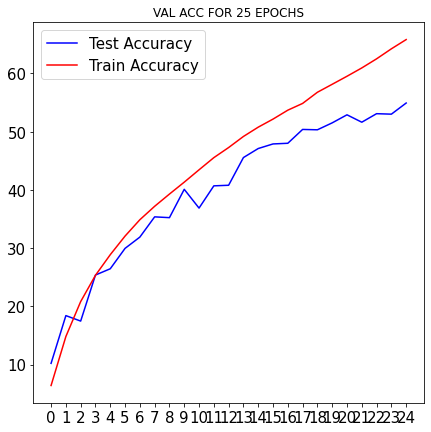

In [15]:
new_model.plot_train_test_acc()

In [16]:
new_model.total_accuracy()

Accuracy of the network on the 10000 test images: 54 %
